In [ ]:
"""
agp_pipeline.py - Interpretable ML case study on American Gut data

Overview
    Single-split, interpretable machine-learning pipeline to classify self-reported
    mental health status (depression, bipolar disorder, or schizophrenia) using
    American Gut Project (AGP) 16S profiles plus engineered diversity features.

Truth-in-methods
    - Data split: One stratified split (train 80% / held-out test 20%).
    - Tuning: 5-fold GridSearchCV on the training portion ONLY (scoring = ROC-AUC).
    - Final evaluation: Once on the held-out test set; reports accuracy, precision, recall,
      F1 (positive class), ROC-AUC, PR-AUC, and confusion matrix.
    - Class imbalance handling: SMOTE on training folds (where used) and scale_pos_weight
      for boosted trees (XGBoost, LightGBM).
    Interpretability: TreeSHAP computed on the held-out test set.
     - Global importance for LightGBM = mean absolute SHAP across ALL test cases.
     - Waterfall plots are generated ONLY for correctly predicted positive (true-positive) cases.

Data & labels
    - Inputs (CSV): OTU relative abundance table, label vector from AGP metadata
      ("depression_bipolar_schizophrenia" mapped to {0,1}), (optional) taxonomy map to verify strains.
    - OTUs clustered at 97%; taxonomy from Greengenes 13_8; species-level claims are limited.

Outputs
    - Printed metrics for each model; confusion matrices; ROC/PR summary numbers.
    - Global SHAP bar plot for LightGBM; SHAP waterfall plots for true positives.

Caveats
    - Findings are hypothesis-generating model associations, not causal effects.
    - Mental health status was mainly self-diagnosed
    - 97% OTU clustering is considered to underestimate microbial diversity slightly

Reproducibility
    - random_state = 42, test_size = 0.20, stratify = y.
    - All preprocessing fit on training data ONLY; transformations applied to test.
"""

'\nagp_pipeline.py — Interpretable ML case study on American Gut data (truthful documentation)\n\nOverview\n    Single-split, interpretable machine-learning pipeline to classify self-reported\n    mental health status (depression, bipolar disorder, or schizophrenia) using\n    American Gut Project (AGP) 16S profiles plus engineered diversity features.\n\nTruth-in-methods (matches this script)\n    • Data split: ONE stratified split (train 80% / held-out test 20%) with fixed seed (42).\n    • Tuning: 5-fold GridSearchCV on the training portion ONLY (scoring = ROC-AUC).\n    • Final evaluation: ONCE on the held-out test set; reports accuracy, precision, recall,\n      F1 (positive class), ROC-AUC, PR-AUC, and confusion matrix.\n    • Class imbalance handling: SMOTE on training folds (where used) and scale_pos_weight\n      for boosted trees (XGBoost, LightGBM).\n    • Interpretability: TreeSHAP computed on the held-out test set.\n        - Global importance for LightGBM = mean absolute S

First, run this code to mount colab to drive and download all required packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q pandas numpy scikit-learn xgboost lightgbm imbalanced-learn shap biom-format h5py matplotlib seaborn

SyntaxError: invalid syntax (ipython-input-540962539.py, line 1)

Then, log into drive and upload all files downloaded from zenodo archive to the google drive folder "Colab Notebooks" - this will appear after you mount allow Colab to access google drive files.

Data Trimming

In [ ]:
# Data Trimming (AGP subset)
#
# What this does
#   - Load AGP metadata + OTU table.
#   - Keep adult samples that actually answered mental-health items.
#   - Align sample IDs across metadata/OTUs and drop anything without labels.
#   - Write clean CSVs used in the next step.
#
# Inputs (paths set just below)
#   - sample_metadata.tsv   - AGP/Qiita metadata
#   - otu_table.tsv/.biom   - OTU counts (rows are samples)
#
# Label rule (binary):
#   - case = 1 if ANY of ['depress','anxiety','mental','psych','stress'] is true.
#
# Outputs
#   - filtered_meta.csv     - Metadata for kept samples (adult + labeled)
#   - filtered_otus.csv     - OTU table for the same sample IDs
#
# Notes
#   This block does zero modeling, only filtering and ID alignment.




!pip install biom-format h5py --quiet

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from biom import load_table

biom_fp = '/content/drive/MyDrive/Colab Notebooks/AG_100nt_even1k.biom'
meta_fp = '/content/drive/MyDrive/Colab Notebooks/10317_20250712-045924.txt'

metadata = pd.read_csv(meta_fp, sep='\t', low_memory=False, encoding='utf-8', on_bad_lines='skip')
metadata = metadata.rename(columns={'sample_name': 'sample_id'})
metadata['sample_id'] = metadata['sample_id'].astype(str)

table = load_table(biom_fp)
otu_df = table.to_dataframe(dense=True).T  # rows = samples
print(f" Loaded BIOM table with shape: {otu_df.shape}")

print("Sample OTU Index Examples:")
print(otu_df.index[:10].tolist())

print("\n Sample metadata IDs Examples:")
print(metadata['sample_id'].head(10).tolist())

otu_df.index = otu_df.index.str.extract(r'(\d{9})', expand=False)
metadata['sample_id'] = metadata['sample_id'].str.extract(r'(\d{9})', expand=False)

otu_df = otu_df[otu_df.index.notna()]
metadata = metadata[metadata['sample_id'].notna()]

shared_ids = otu_df.index.intersection(metadata['sample_id'])
otu_df = otu_df.loc[shared_ids]
metadata = metadata.set_index('sample_id').loc[shared_ids]
print(f"Merged OTU with metadata: {otu_df.shape}")

mental_cols = [col for col in metadata.columns if any(x in col.lower() for x in ['depress', 'anxiety', 'mental', 'psych', 'stress'])]
print(f"Found {len(mental_cols)} potential mental health columns.")

non_empty_mask = metadata[mental_cols].notna().any(axis=1)
filtered_metadata = metadata[non_empty_mask]
filtered_otu = otu_df.loc[filtered_metadata.index]

print(f"Retained {filtered_metadata.shape[0]} samples with mental health data")
print(f"OTU shape after filtering: {filtered_otu.shape}")

for col in mental_cols:
    col_data = filtered_metadata[col].dropna()
    if not col_data.empty:
        print(f"\n {col}:")
        print(col_data.value_counts(dropna=False).head())

filtered_metadata.reset_index().to_csv('/content/filtered_metadata.csv', index=False)
filtered_otu.to_csv('/content/filtered_otu.csv')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 31.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


MessageError: Error: credential propagation was unsuccessful

Feature Engineering

In [ ]:
# Feature Engineering (microbiome + covariates)
#
# What this does
#   - Convert OTU counts to relative abundance per sample.
#   - Log-transform rel. abundance (log10(x + 1e-6)) to tame extremes.
#   - Alpha diversity: Shannon, Simpson; plus OTU richness.
#   - Broad phylum ratios known to contribute to microbiome health:
#       - Firmicutes:Bacteroidetes, - Actinobacteria:Proteobacteria,
#       - Firmicutes:Proteobacteria, - Bacteroidetes:Actinobacteria.
#   - Add covariates when present (age, sex, BMI, diet, meds …).
#   - Build X (features) and y (labels) with matching row order and save.
#
# Inputs
#   - filtered_otus.csv
#   - filtered_meta.csv
#
# Outputs
#   - otu_processed.csv   - final feature matrix (engineered + rel/log OTUs)
#   - y_labels.csv        - 0/1 labels aligned to X rows


from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

otu_path = "/content/drive/MyDrive/Colab Notebooks/filtered_otu.csv"
meta_path = "/content/drive/MyDrive/Colab Notebooks/filtered_metadata.csv"
taxonomy_path = "/content/drive/MyDrive/Colab Notebooks/97_otu_taxonomy.txt"

otu_df = pd.read_csv(otu_path, index_col=0)
meta_df = pd.read_csv(meta_path, index_col=0, low_memory=False)
tax_df = pd.read_csv(taxonomy_path, sep='\t', header=None, names=["OTU_ID", "taxonomy"])

otu_df.index = otu_df.index.astype(str).str.strip()
meta_df.index = meta_df.index.astype(str).str.strip()
otu_df = otu_df[~otu_df.index.duplicated()]
meta_df = meta_df[~meta_df.index.duplicated()]
tax_df["OTU_ID"] = tax_df["OTU_ID"].astype(str).str.strip()
tax_map = dict(zip(tax_df["OTU_ID"], tax_df["taxonomy"]))

y_raw = meta_df["depression_bipolar_schizophrenia"]
y_raw = y_raw.replace({
    "Diagnosed by a medical professional (doctor, physician assistant)": 1,
    "I do not have this condition": 0
})

y = y_raw[y_raw.isin([0, 1])].astype(int)
y = y[y.isin([0, 1])]

shared_ids = sorted(set(otu_df.index) & set(y.index))
otu_df = otu_df.loc[shared_ids]
meta_df = meta_df.loc[shared_ids]
y = y.loc[shared_ids]

otu_rel = otu_df.div(otu_df.sum(axis=1), axis=0)

def get_otus_by_phylum(phylum):
    return [k for k, v in tax_map.items() if f'p__{phylum}' in v and k in otu_rel.columns]

ratios = {
    "Firmicutes_Bacteroidetes_Ratio": ("Firmicutes", "Bacteroidetes"),
    "Actinobacteria_Proteobacteria_Ratio": ("Actinobacteria", "Proteobacteria"),
    "Firmicutes_Proteobacteria_Ratio": ("Firmicutes", "Proteobacteria"),
    "Bacteroidetes_Actinobacteria_Ratio": ("Bacteroidetes", "Actinobacteria"),
}

for name, (p1, p2) in ratios.items():
    p1_otus = get_otus_by_phylum(p1)
    p2_otus = get_otus_by_phylum(p2)
    p1_sum = otu_rel[p1_otus].sum(axis=1) if p1_otus else pd.Series(0.01, index=otu_rel.index)
    p2_sum = otu_rel[p2_otus].sum(axis=1) if p2_otus else pd.Series(0.01, index=otu_rel.index)
    otu_rel[name] = p1_sum / p2_sum.replace(0, 0.01)
    print(f" Added {name}: {len(p1_otus)} {p1} / {len(p2_otus)} {p2} OTUs")

def shannon_index(row):
    probs = row[row > 0]
    return -np.sum(probs * np.log2(probs))

def simpson_index(row):
    probs = row[row > 0]
    return 1 - np.sum(probs ** 2)

otu_rel["Shannon_Index"] = otu_rel.apply(shannon_index, axis=1)
otu_rel["Simpson_Index"] = otu_rel.apply(simpson_index, axis=1)
otu_rel["OTU_Richness"] = (otu_df > 0).sum(axis=1).reindex(otu_rel.index)

print(" Added Shannon Index, Simpson Index, OTU Richness")

extra_features = []
for col in ["age", "sex", "bmi", "diet"]:
    if col in meta_df.columns:
        meta_col = meta_df[col].dropna()
        meta_col.index = meta_col.index.astype(str).str.strip()
        meta_col = meta_col.loc[meta_col.index.intersection(otu_rel.index)]
        if meta_col.dtype == object:
            meta_col = pd.get_dummies(meta_col, prefix=col)
        else:
            meta_col = meta_col.to_frame()
        extra_features.append(meta_col)

if extra_features:
    extra_df = pd.concat(extra_features, axis=1)
    extra_df = extra_df.loc[~extra_df.index.duplicated()]
    otu_rel = pd.concat([otu_rel, extra_df], axis=1)
    otu_rel = otu_rel.loc[~otu_rel.index.duplicated()]
min_required = int(0.9 * otu_rel.shape[1])
otu_rel = otu_rel.dropna(thresh=min_required)
y = y.loc[otu_rel.index]
print(f" Added metadata: {extra_df.shape[1]} features")

otu_rel.to_csv("/content/drive/MyDrive/Colab Notebooks/otu_processed.csv")
y.to_csv("/content/drive/MyDrive/Colab Notebooks/y_labels.csv")
print("saved")


MessageError: Error: credential propagation was unsuccessful

Model Training & Interpretation

Mounted at /content/drive

 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        37
           1       0.20      0.20      0.20        10

    accuracy                           0.66        47
   macro avg       0.49      0.49      0.49        47
weighted avg       0.66      0.66      0.66        47

 ROC AUC: 0.519
 PR AUC: 0.227
Confusion Matrix:
[[29  8]
 [ 8  2]]


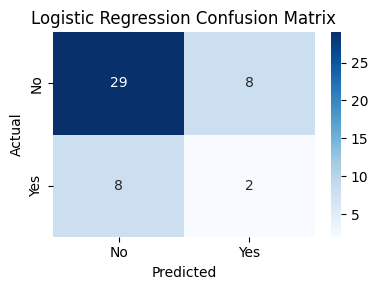


 Model: Random Forest
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        37
           1       0.00      0.00      0.00        10

    accuracy                           0.79        47
   macro avg       0.39      0.50      0.44        47
weighted avg       0.62      0.79      0.69        47

 ROC AUC: 0.507
 PR AUC: 0.218
Confusion Matrix:
[[37  0]
 [10  0]]


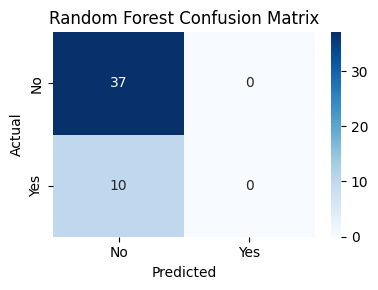


 Model: XGBoost
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        37
           1       0.10      0.10      0.10        10

    accuracy                           0.62        47
   macro avg       0.43      0.43      0.43        47
weighted avg       0.62      0.62      0.62        47

 ROC AUC: 0.492
 PR AUC: 0.191
Confusion Matrix:
[[28  9]
 [ 9  1]]


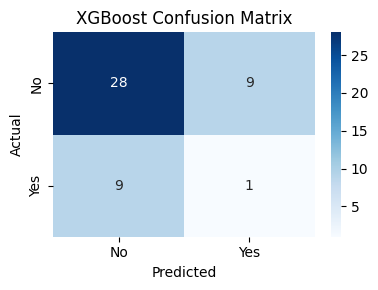


 Model: Gradient Boosting
              precision    recall  f1-score   support

           0       0.80      0.95      0.86        37
           1       0.33      0.10      0.15        10

    accuracy                           0.77        47
   macro avg       0.56      0.52      0.51        47
weighted avg       0.70      0.77      0.71        47

 ROC AUC: 0.459
 PR AUC: 0.273
Confusion Matrix:
[[35  2]
 [ 9  1]]


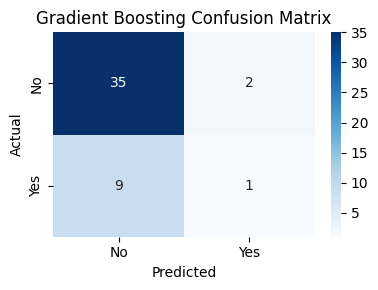


 Model: LightGBM
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        37
           1       0.27      0.30      0.29        10

    accuracy                           0.68        47
   macro avg       0.54      0.54      0.54        47
weighted avg       0.69      0.68      0.69        47

 ROC AUC: 0.559
 PR AUC: 0.246
Confusion Matrix:
[[29  8]
 [ 7  3]]


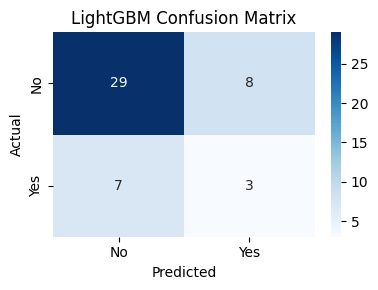


 Model: Stacking
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        37
           1       0.00      0.00      0.00        10

    accuracy                           0.79        47
   macro avg       0.39      0.50      0.44        47
weighted avg       0.62      0.79      0.69        47

 ROC AUC: 0.532
 PR AUC: 0.313
Confusion Matrix:
[[37  0]
 [10  0]]


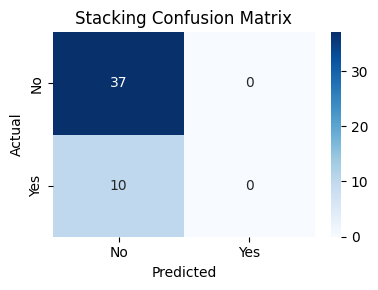


 Model: Voting
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        37
           1       0.25      0.10      0.14        10

    accuracy                           0.74        47
   macro avg       0.52      0.51      0.50        47
weighted avg       0.68      0.74      0.70        47

 ROC AUC: 0.514
 PR AUC: 0.231
Confusion Matrix:
[[34  3]
 [ 9  1]]


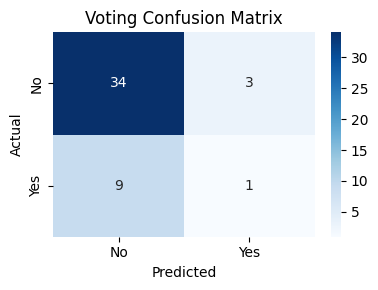


\SHAP Waterfall Plots for Correctly Predicted Yes Cases

XGBoost - 1 Correctly Predicted Yes Cases

XGBoost SHAP for Correctly Predicted Yes Case 1 (Index: 13588)


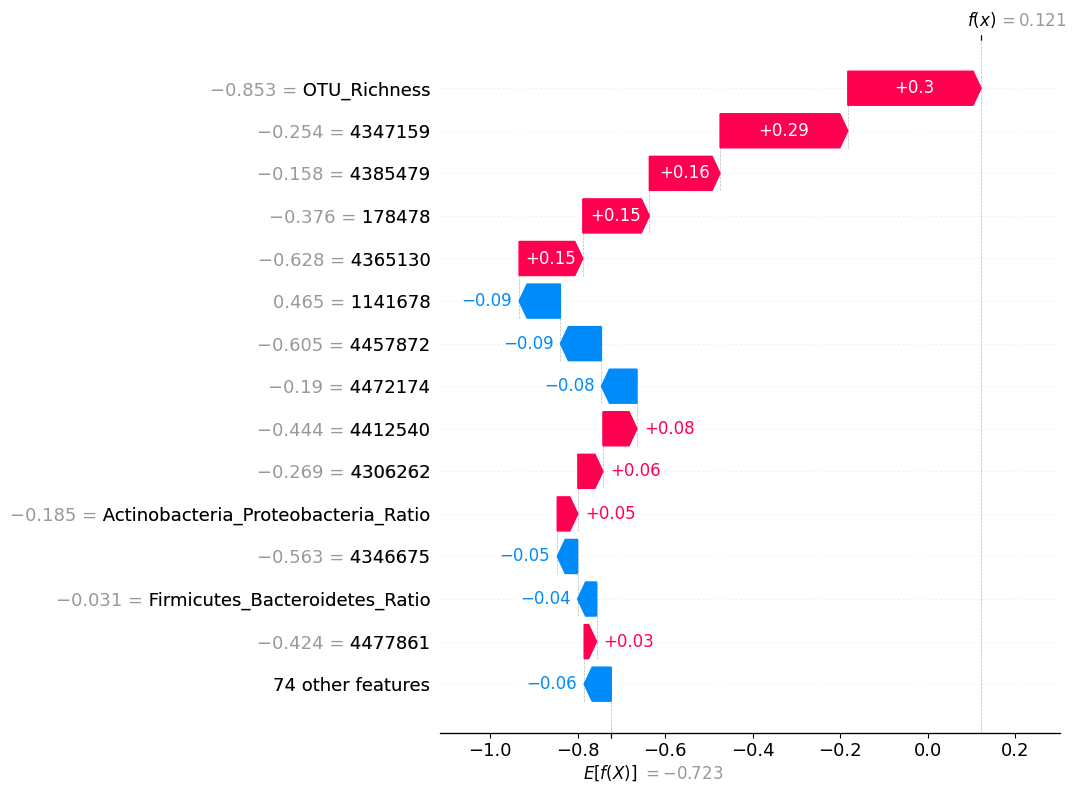


Gradient Boosting - 1 Correctly Predicted Yes Cases

Gradient Boosting SHAP for Correctly Predicted Yes Case 1 (Index: 8972)


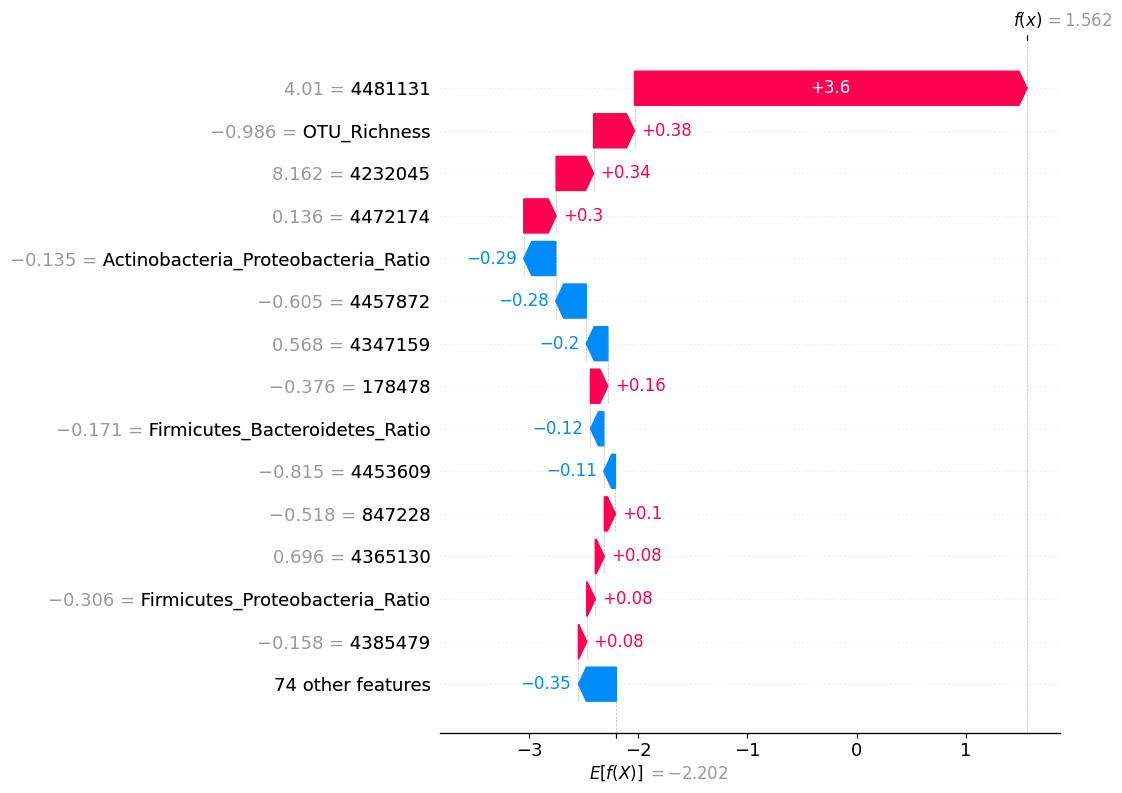


LightGBM - 3 Correctly Predicted Yes Cases

LightGBM SHAP for Correctly Predicted Yes Case 1 (Index: 13588)


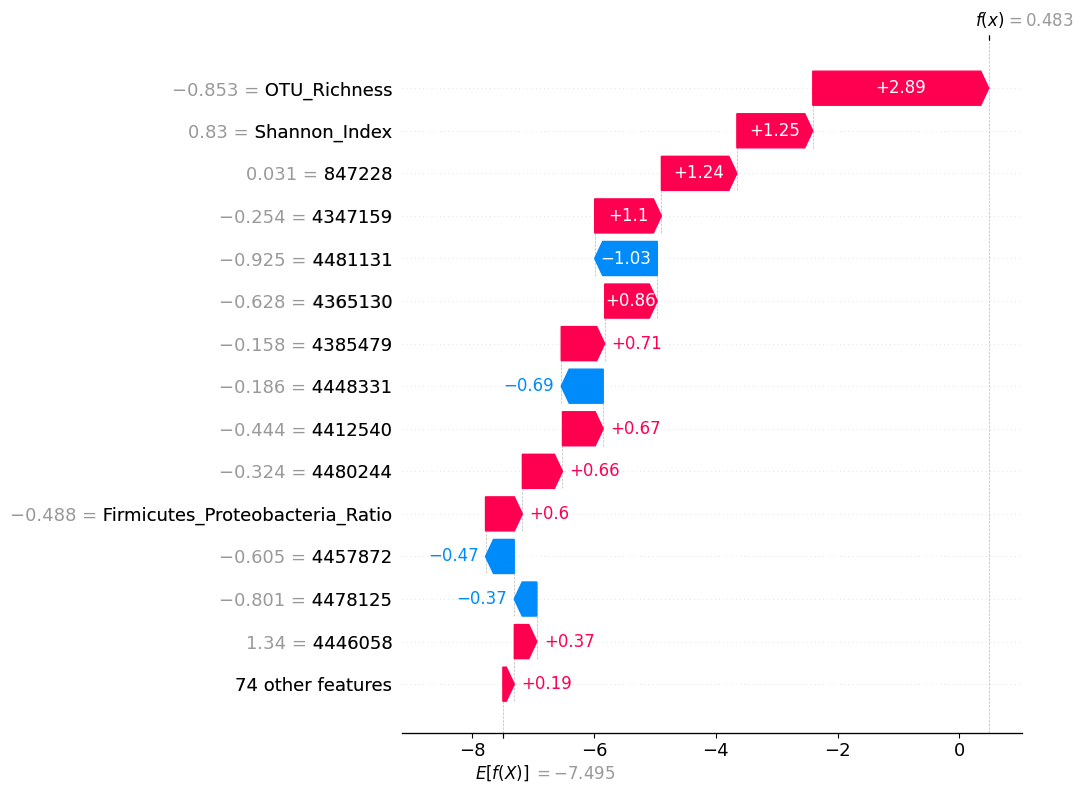


LightGBM SHAP for Correctly Predicted Yes Case 2 (Index: 8983)


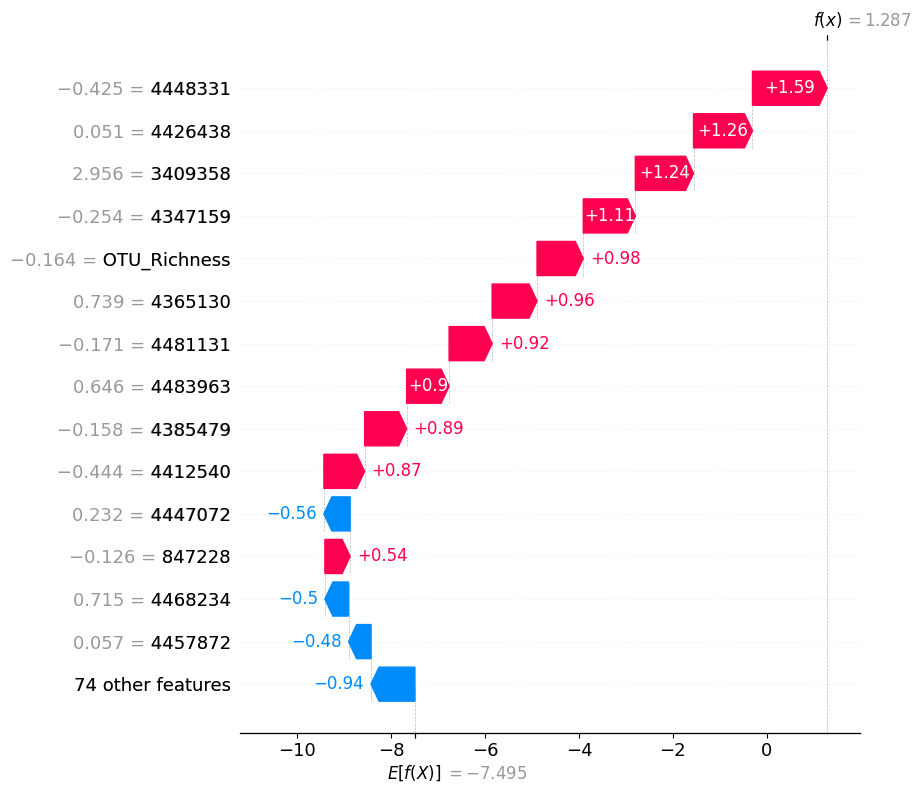


LightGBM SHAP for Correctly Predicted Yes Case 3 (Index: 6852)


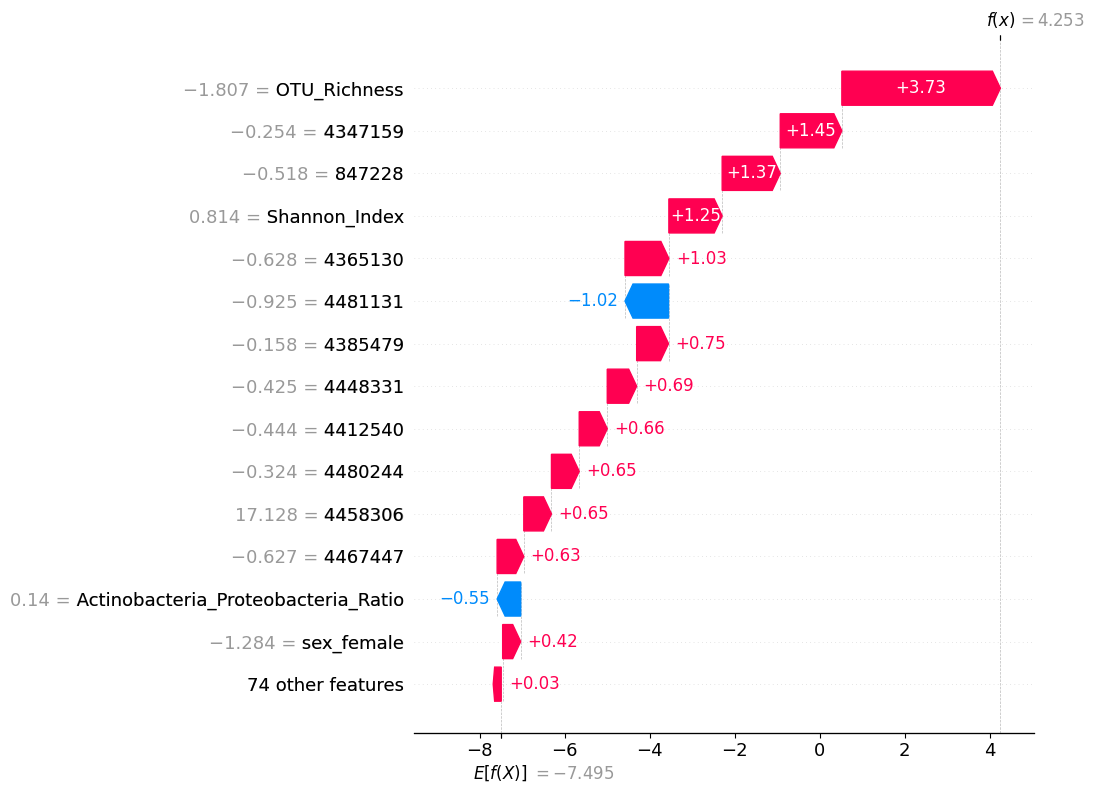


Top SHAP Features (LightGBM):


,Feature,SHAP Importance
84,OTU_Richness,1.881110
16,3409358,0.951188
68,847228,0.905187
59,4347159,0.853343
5,4483963,0.837373
64,4365130,0.812933
24,4426438,0.633888
7,4412540,0.597945
14,4385479,0.496971
8,4448331,0.470374


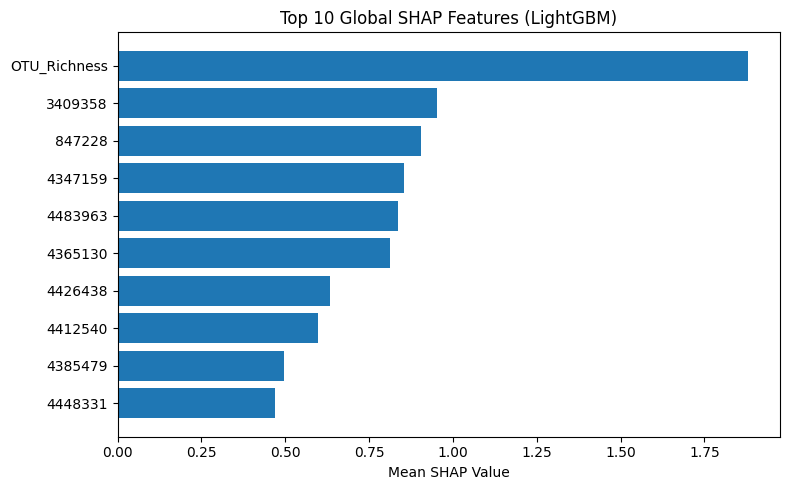

In [ ]:
# Model Training & Interpretation
#
# What this does
#   - Load X/y, stratified 80/20 split (fixed seed).
#   - Scale only models that need it (e.g., LogisticRegression via StandardScaler);
#     tree models (RF/GB/XGB/LGBM) use raw features.
#   - Handle class imbalance ONE way:
#     - EITHER use `scale_pos_weight` from the ORIGINAL y_train (pre-SMOTE),
#     OR apply SMOTE on the training fold
#   - GridSearchCV (5-fold, ROC-AUC) over:
#     - LogisticRegression, RandomForest, GradientBoosting, XGBoost, LightGBM.
#   - Evaluate on the held-out test set:
#     - accuracy, precision, recall, F1 (positive class), ROC-AUC, PR-AUC,
#     and a confusion matrix.
#   Interpret the best tree model with SHAP:
#     global importance mean SHAP + a few high-confidence positive cases.
#
# Inputs
#   - otu_processed.csv
#   - y_labels.csv
#
# Outputs (printed/plots)
#   - Test metrics + classification report.
#   - ROC and PR curves, confusion matrix heatmap.
#   - SHAP global bar plot + individual force/decision plots.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

otu_rel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/otu_processed.csv", index_col=0, low_memory=False)
y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/y_labels.csv", index_col=0).squeeze()

def simplify_taxonomy(taxonomy_str):
    try:
        parts = taxonomy_str.split(';')
        for level in reversed(parts):
            if level.strip():
                return level.strip().split("__")[-1]
        return taxonomy_str
    except:
        return taxonomy_str

taxonomy_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/97_otu_taxonomy.txt", sep='\t', header=None, names=['OTU', 'Taxonomy'])
taxonomy_df["Simple"] = taxonomy_df["Taxonomy"].apply(simplify_taxonomy)
taxonomy_dict = taxonomy_df.set_index("OTU")['Simple'].to_dict()

col_thresh = int(0.3 * len(otu_rel))
otu_rel = otu_rel.dropna(axis=1, thresh=col_thresh)
otu_rel = otu_rel.fillna(otu_rel.median())

engineered_features = [
    'Firmicutes_Bacteroidetes_Ratio', 'Actinobacteria_Proteobacteria_Ratio',
    'Firmicutes_Proteobacteria_Ratio', 'Bacteroidetes_Actinobacteria_Ratio',
    'Shannon_Index', 'Simpson_Index', 'OTU_Richness'
]
for feat in engineered_features:
    if feat not in otu_rel.columns:
        raise ValueError(f"Missing engineered feature: {feat}")

y = y.loc[otu_rel.index]

selector = VarianceThreshold(threshold=0.0001)
X_filtered = selector.fit_transform(otu_rel)
selected_features = otu_rel.columns[selector.get_support()].tolist()
for feat in engineered_features:
    if feat not in selected_features:
        selected_features.append(feat)
otu_rel_filtered = otu_rel[selected_features]

def rename_features_with_taxonomy(df, taxonomy_dict):
    return df.rename(columns=lambda col: taxonomy_dict.get(col, col))

otu_rel_named = rename_features_with_taxonomy(otu_rel_filtered, taxonomy_dict)

X_train, X_test, y_train, y_test = train_test_split(
    otu_rel_named, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

if min(Counter(y_train).values()) < 6:
    smote = SMOTE(random_state=42)
    X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

logreg = LogisticRegression(max_iter=1000)
logreg_grid = GridSearchCV(logreg, {'C': [0.01, 0.1, 1, 10, 100]}, cv=5, scoring='roc_auc').fit(X_train_scaled, y_train)

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, {'n_estimators': [100, 300], 'max_depth': [3, 5, None], 'min_samples_split': [2, 5]}, cv=5, scoring='roc_auc').fit(X_train_scaled, y_train)

xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, scale_pos_weight=scale_pos_weight, random_state=42)
xgb_grid = GridSearchCV(xgb, {'n_estimators': [100, 300], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}, cv=5, scoring='roc_auc').fit(X_train_scaled, y_train)

gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}, cv=5, scoring='roc_auc').fit(X_train_scaled, y_train)

lgb = LGBMClassifier(random_state=42, min_gain_to_split=0.0, min_data_in_leaf=1, verbose=-1)
lgb_grid = GridSearchCV(lgb, {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'num_leaves': [31, 50]}, cv=5, scoring='roc_auc').fit(X_train_scaled, y_train)

stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_grid.best_estimator_), ('rf', rf_grid.best_estimator_), ('lgb', lgb_grid.best_estimator_)],
    final_estimator=LogisticRegression(max_iter=1000)
).fit(X_train_scaled, y_train)

voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_grid.best_estimator_), ('rf', rf_grid.best_estimator_), ('lgb', lgb_grid.best_estimator_)
], voting='soft').fit(X_train_scaled, y_train)

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n Model: {name}")
    print(classification_report(y_test, y_pred))
    print(f" ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    print(f" PR AUC: {auc(recall, precision):.3f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

models = {
    "Logistic Regression": logreg_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_,
    "Gradient Boosting": gb_grid.best_estimator_,
    "LightGBM": lgb_grid.best_estimator_,
    "Stacking": stacking_clf,
    "Voting": voting_clf
}

for name, model in models.items():
    evaluate_model(name, model, X_test_scaled, y_test)

print("\n\SHAP Waterfall Plots for Correctly Predicted Yes Cases")
for name, model in models.items():
    if name in ["Random Forest", "XGBoost", "Gradient Boosting", "LightGBM"]:
        explainer = shap.Explainer(model, X_train_scaled)
        shap_values = explainer(X_test_scaled, check_additivity=False)
        y_pred = model.predict(X_test_scaled)
        correct_yes_mask = (y_test == 1) & (y_pred == 1)
        correct_yes_indices = np.where(correct_yes_mask)[0]
        if len(correct_yes_indices) > 0:
            print(f"\n{name} - {len(correct_yes_indices)} Correctly Predicted Yes Cases")
            for i, idx in enumerate(correct_yes_indices):
                sample_idx = X_test_scaled.index[idx]
                print(f"\n{name} SHAP for Correctly Predicted Yes Case {i+1} (Index: {sample_idx})")
                shap.plots.waterfall(shap_values[idx], max_display=15)

explainer_lgb = shap.Explainer(lgb_grid.best_estimator_, X_train_scaled)
shap_values_lgb = explainer_lgb(X_test_scaled, check_additivity=False)
shap_values_mean = np.abs(shap_values_lgb.values).mean(axis=0)
top_features = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'SHAP Importance': shap_values_mean
}).sort_values(by='SHAP Importance', ascending=False)

print("\nTop SHAP Features (LightGBM):")
display(top_features.head(10))

plt.figure(figsize=(8, 5))
plt.barh(top_features['Feature'].head(10)[::-1], top_features['SHAP Importance'].head(10)[::-1])
plt.xlabel("Mean SHAP Value")
plt.title("Top 10 Global SHAP Features (LightGBM)")
plt.tight_layout()
plt.show()
